<a href="https://colab.research.google.com/github/nxxk23/AI-Engineer/blob/main/extract/EasyOCR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **convert pdf to img**

In [1]:
!nvidia-smi #using GPU is faster

Mon Sep  2 02:09:17 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P8              13W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!sudo apt-get install ghostscript
!pip install opencv-python easyocr

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fonts-droid-fallback fonts-noto-mono fonts-urw-base35 libgs9 libgs9-common
  libidn12 libijs-0.35 libjbig2dec0 poppler-data
Suggested packages:
  fonts-noto fonts-freefont-otf | fonts-freefont-ttf fonts-texgyre
  ghostscript-x poppler-utils fonts-japanese-mincho | fonts-ipafont-mincho
  fonts-japanese-gothic | fonts-ipafont-gothic fonts-arphic-ukai
  fonts-arphic-uming fonts-nanum
The following NEW packages will be installed:
  fonts-droid-fallback fonts-noto-mono fonts-urw-base35 ghostscript libgs9
  libgs9-common libidn12 libijs-0.35 libjbig2dec0 poppler-data
0 upgraded, 10 newly installed, 0 to remove and 49 not upgraded.
Need to get 16.7 MB of archives.
After this operation, 63.0 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 fonts-droid-fallback all 1:6.0.1r16-1.1build1 [1,805 kB]


In [4]:
!pwd

/content


In [5]:
!mkdir -p /content/resume/images/
# !gs -dBATCH -dNOPAUSE -sDEVICE=pngalpha -r300 -sOutputFile="/content/resume/images/page_%d.png" "{pdf_path}"

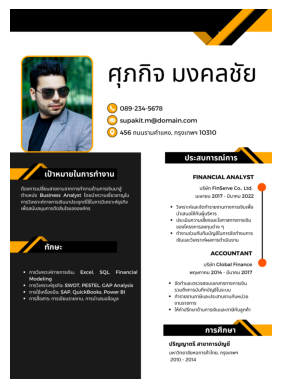

In [ ]:
import cv2
from matplotlib import pyplot as plt

image = cv2.imread("/content/resume/images/page_1.png")

# Convert the image from BGR (OpenCV format) to RGB (Matplotlib format)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the image
plt.imshow(image_rgb)
plt.axis('off')  # Hide axis
plt.show()


In [ ]:
import easyocr

# Create an EasyOCR Reader
reader = easyocr.Reader(['th', 'en'])

# Perform OCR on an image
result = reader.readtext('/content/resume/images/page_1.png')

# Print the results
for detection in result:
    print(detection)


Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

/usr/local/lib/python3.10/dist-packages/easyocr/detection.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(copyStateDict(torch.load(trained_model, ma

([[905, 496], [2344, 496], [2344, 763], [905, 763]], ' ศุภกิจฺ มงคลชัย', 0.5152074046732871)
([[1033, 910], [1452, 910], [1452, 975], [1033, 975]], '089-234-5678', 0.9984851042906709)
([[1031, 1012], [1781, 1012], [1781, 1102], [1031, 1102]], ' supakit.m@domain.com', 0.6197551632104747)
([[1032, 1139], [1960, 1139], [1960, 1216], [1032, 1216]], '456 ถนนรามคำแหง, กรุงเทพฯ 10310', 0.5512611713476971)
([[1647, 1372], [2166, 1372], [2166, 1450], [1647, 1450]], 'ประสบการณ์การ', 0.7771163684549081)
([[319, 1519], [999, 1519], [999, 1605], [319, 1605]], 'เป้าหมายในการทำงาน', 0.6448775157485162)
([[1728, 1564], [2315, 1564], [2315, 1621], [1728, 1621]], 'financial analyst', 0.860918707032338)
([[92, 1664], [1064, 1664], [1064, 1741], [92, 1741]], 'ต้องการเปลี่ยนสายงานจากการทำงานด้านการเงินมาสู่', 0.861472306497453)
([[1791, 1675], [2301, 1675], [2301, 1728], [1791, 1728]], ' บริษัท finserve co., ltd.', 0.32924344731795646)
([[97, 1739], [264, 1739], [264, 1791], [97, 1791]], ' ตำแหน่ง', 0.5140

In [ ]:
def extract_text_from_ocr(ocr_data):
    sorted_data = sorted(ocr_data, key=lambda x: x[0][0][1])
    plain_text = ""
    for _, text, _ in sorted_data:
        plain_text += text.strip() + "\n"  # Add newline to separate lines of text

    return plain_text.strip()

# Extract plain text
text1 = extract_text_from_ocr(result)

# Print the extracted text
print(text1)

ศุภกิจฺ มงคลชัย
089-234-5678
supakit.m@domain.com
456 ถนนรามคำแหง, กรุงเทพฯ 10310
ประสบการณ์การ
เป้าหมายในการทำงาน
financial analyst
ต้องการเปลี่ยนสายงานจากการทำงานด้านการเงินมาสู่
บริษัท finserve co., ltd.
business analyst โดยนำความเชี่ยวชาญใน
ตำแหน่ง
เมษายน 2017
มีนาคม 2022
การวิเคราะห์ทางการเงินมาประยุกต์ใช้ในการวิเคราะห์ธุรกิจ
วิเคราะห์และจัดทำรายงานทางการเงินเพือ
เพื่อสนับสนุนการตัดสินใจขององค์กร
นำเสนอให้กับผู้บริหาร
ประเมินความเสียงและโอกาสทางการเงิน
ของโครงการลงทุนต่างฺๆ
ทำงานร่วมกับทีมบัญชีในการจัดทางบการ
เงินและวิเคราะห์ผลการดำเนินงาน
ทักษะ
accountant
บริษัท global finance
sql,
financial
การวิเคราะห์ทางการเงิน:
excel,
พฤษภาคม 2014
มีนาคม 2017
modeling
จัดทำและตรวจสอบเอกสารทางการเงิน
การวิเคราะห์ธุรกิจ: swot, pestel, cap analysis
รวมถึงการบันทึกบัญชีในระบบ
การใช้เครื่องมือ: sap, quickbooks, power bi
ทำรายงานภาษีและประสานงานกับหน่วย
การสื่อสาร: การเขียนรายงาน, ฺการนำเสนอข้อมูล
งานราชการ
ให้คำปรึกษาด้านการเงินและภาษีกับลูกค้า
การศึกษา
ปริญญาตรี สาขาการบัญชี
มหาวิทยาลัยหอการค้าไท

# test more

In [ ]:
pdf_path2 = "/content/drive/MyDrive/AIEngineer/resume/resume_LLM/Resume BA 2.pdf"

In [ ]:
!mkdir -p /content/resume/images/
!gs -dBATCH -dNOPAUSE -sDEVICE=pngalpha -r300 -sOutputFile="/content/resume/images/page_2.png" "{pdf_path2}"

GPL Ghostscript 9.55.0 (2021-09-27)
Copyright (C) 2021 Artifex Software, Inc.  All rights reserved.
This software is supplied under the GNU AGPLv3 and comes with NO WARRANTY:
see the file COPYING for details.
Processing pages 1 through 1.
Page 1


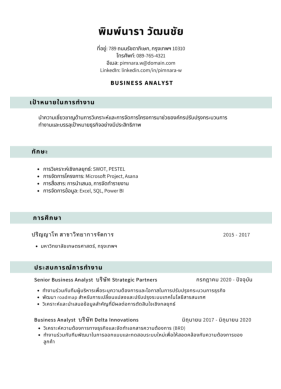

In [ ]:
import cv2
from matplotlib import pyplot as plt

image = cv2.imread("/content/resume/images/page_2.png")

# Convert the image from BGR (OpenCV format) to RGB (Matplotlib format)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the image
plt.imshow(image_rgb)
plt.axis('off')  # Hide axis
plt.show()


In [ ]:
import easyocr

# Create an EasyOCR Reader
reader = easyocr.Reader(['th', 'en'])

# Perform OCR on an image
result = reader.readtext('/content/resume/images/page_2.png')

# Print the results
for detection in result:
    print(detection)


([[832, 152], [1651, 152], [1651, 263], [832, 263]], 'พิมพ์นารา วัฒนชัย', 0.5368205478285532)
([[927, 344], [1666, 344], [1666, 408], [927, 408]], '789 ถนนรัชดาภิเษก, กรุงเทพฯ 10310', 0.3715360863598928)
([[998, 408], [1477, 408], [1477, 471], [998, 471]], 'โทรศัพท์: 089-765-4321', 0.8343831253413814)
([[905, 480], [1570, 480], [1570, 548], [905, 548]], 'อีเมล: pimnara.w@domain. com', 0.5601538703261414)
([[850, 554], [1633, 554], [1633, 616], [850, 616]], 'linkedin: linkedin . com in pimnara w', 0.39757898287670096)
([[949, 666], [1548, 666], [1548, 732], [949, 732]], 'busiess analvst', 0.5557068779061828)
([[178, 847], [805, 847], [805, 915], [178, 915]], 'เป้าหมายในการทำงาน', 0.8459498744916895)
([[258, 987], [2066, 987], [2066, 1073], [258, 1073]], 'นำความเชี่ยวชาญด้านการวิเคราะห์และการจัดการโครงการมาช่วยองค์กรปรับปรุงกระบวนการ', 0.7323461549311283)
([[262, 1061], [1250, 1061], [1250, 1136], [262, 1136]], 'ทำงานและบรรลุเป้าหมายธุรกิจอย่างมีประสิทธิภาพ', 0.7432949317415334)
([[200, 

In [ ]:
def extract_text_from_ocr(ocr_data):
    sorted_data = sorted(ocr_data, key=lambda x: x[0][0][1])
    plain_text = ""
    for _, text, _ in sorted_data:
        plain_text += text.strip() + "\n"  # Add newline to separate lines of text

    return plain_text.strip()

# Extract plain text
text2 = extract_text_from_ocr(result)

# Print the extracted text
print(text2)

พิมพ์นารา วัฒนชัย
ที่อยู่:
789 ถนนรัชดาภิเษก, กรุงเทพฯ 10310
โทรศัพท์: 089-765-4321
อีเมล: pimnara.w@domain. com
linkedin: linkedin . com in pimnara w
busiess analvst
เป้าหมายในการทำงาน
นำความเชี่ยวชาญด้านการวิเคราะห์และการจัดการโครงการมาช่วยองค์กรปรับปรุงกระบวนการ
ทำงานและบรรลุเป้าหมายธุรกิจอย่างมีประสิทธิภาพ
ทักษะ
การวิเคราะห์เชิงกลยุทธ์: swot pestel
การจัดการโครงการ: microsoft project, asana
การสื่อสาร: การนำเสนอ,การจัดทำรายงาน
การจัดการข้อมูล: excel., sql, power bi
การศึกษา
ปริญญาโท สาขาวิทยาการจัดการ
2015
2017
มหาวิทยาลัยเกษตรศาสตร์, กรุงเทพฯ
ประสบการณ์การทำงาน
senior business analyst บริษัท strategic partners
ปัจจุบัน
กรกฎาคม 2020
ทำงานร่วมกับทีมผู้บริหารเพื่อระบุความต้องการและโอกาสในการปรับปรุงกระบวนการธุรกิจ
พัฒนา roadmap สำหรับการเปลี่ยนแปลงและปรับปรุงระบบเทคโนโลยีสารสนเทศ
วิเคราะห์และนำเสนอข้อมูลสำคัญที่มีผลต่อการตัดสินใจเชิงกลยุทธ์
business analyst บริษัท delta innovations
มิถุนายน 2017
มิถุนายน 2020
วิเคราะห์1ความต้องการทางธุรกิจและจัดทำเอกสารความต้องการ (brd)
ทำงานร่วมกับท

In [ ]:
import pandas as pd
# Create DataFrame with 1 column and 2 rows
df = pd.DataFrame({
    'Texts': [text1, text2]
})

df

,Texts
0,ศุภกิจฺ มงคลชัย\n089-234-5678\nsupakit.m@domai...
1,พิมพ์นารา วัฒนชัย\nที่อยู่:\n789 ถนนรัชดาภิเษก...


## **single pdf pipeline**

In [ ]:
import os
import easyocr
import pandas as pd
import shutil

# Define the function to extract text from images
def extract_text_from_image(image_path):
    reader = easyocr.Reader(['th', 'en'])
    result = reader.readtext(image_path)
    sorted_data = sorted(result, key=lambda x: x[0][0][1])
    plain_text = "\n".join([text for _, text, _ in sorted_data])
    return plain_text

def convert_pdf_to_images(pdf_path, output_dir):
    pdf_filename = os.path.splitext(os.path.basename(pdf_path))[0]  # Get the PDF filename without extension
    output_pattern = os.path.join(output_dir, f"{pdf_filename}_%d.png")  # Use the filename as prefix
    os.system(f'gs -dBATCH -dNOPAUSE -sDEVICE=pngalpha -r300 -sOutputFile="{output_pattern}" "{pdf_path}"')

def process_single_pdf(pdf_path, images_dir):
    # Ensure the output directory exists
    os.makedirs(images_dir, exist_ok=True)

    # Convert PDF to images
    convert_pdf_to_images(pdf_path, images_dir)

    # Extract text from all images related to the PDF file
    pdf_filename = os.path.splitext(os.path.basename(pdf_path))[0]
    text = ""
    for img_file in os.listdir(images_dir):
        if img_file.startswith(pdf_filename):
            img_path = os.path.join(images_dir, img_file)
            text += extract_text_from_image(img_path) + "\n"

    # Store text in a DataFrame
    df = pd.DataFrame({"PDF File": [pdf_path], "Text": [text.strip()]})
    return df

In [ ]:
# Example usage
pdf_path = '/content/resume/pdf/resume 7.pdf'  # Specify the path to the PDF file
images_dir = '/content/resume/images'

resume_7 = process_single_pdf(pdf_path, images_dir)
resume_7


/usr/local/lib/python3.10/dist-packages/easyocr/detection.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(copyStateDict(torch.load(trained_model, ma

,PDF File,Text
0,/content/resume/pdf/resume 7.pdf,ปัญญา วิริยะชัย\n วิศวกรปัญญาประดิษฐ์\nประสบกา...


In [ ]:
print(resume_7['Text'].iloc[0])

ปัญญา วิริยะชัย
 วิศวกรปัญญาประดิษฐ์
ประสบการณ์การฝึกงาน
บัณฑิตจบใหม่สาขาวิทยาการคอมพิวเตอร์ทีมีความ
นักพัฒนาฝึกหัด al
สนใจและทักษะด้าน al และ machine learning ผ่าน
บริษัท ไอที โซลูชันส์ จำกัด
พฤษภาคม 2023 
 สิงหาคม 2023
การทำโปรเจกต์ทั้งในการเรียนและโปรเจกต์ส่วนตัว มี
ประสบการณ์ในการพัฒนาโมเดล machine learning
ช่วยทีมพัฒนาโมเดล machine learning เพื่อพยากรณ์
และ deep learning ด้วย python และ
ยอดขายสินค้า
tensorflow มุ่งมันพัฒนาทักษะ al เพื่อสร้างโซลูชัน
ทำการทดสอบและปรับปรุงโมเดลด้วยเทคนิค
ที่มีประสิทธิภาพ
 hyperparameter tuning
เรียนรู้และใช้เครื่องมือในการจัดการข้อมูลและการฝึก
โมเดล al
ทักษะ
ภาษาโปรแกรม: python, c++
โปรเจกต์ในมหาวิทยาลัย
machine learning: scikit learn,
การวิเคราะห์ภาพใบหน้าเพื่อระบุอารมณ์
tensorflow, keras
การจัดการข้อมูล: sol, pandas, numpy
(emotion recognition)
เครื่องมืออื่นต: git, jupyter notebook
พัฒนาโมเดล deep learning ด้วย tensorflow เพือ
 จำแนกอารมณ์จากภาพใบหน้า
ใช้ชุดข้อมูล fer2013 และฝึกโมเดล cmn เพือเพิ่ม
ช่องทางการติดต่อ
ความแม่นยำในการจำแนก
phone: 080-1

# **build pipeline**
1 นาที 52 วิ

In [6]:
import os
import easyocr
import pandas as pd
import shutil

# Create directories if they don't exist
os.makedirs('/content/resume/pdf', exist_ok=True)
os.makedirs('/content/resume/images', exist_ok=True)

# Copy PDF files to the working directory
pdf_source_dir = '/content/drive/MyDrive/AIEngineer/resume/resume_LLM'
pdf_dest_dir = '/content/resume/pdf'

# Copy all PDF files from the source directory to the destination directory
for pdf_file in os.listdir(pdf_source_dir):
    if pdf_file.lower().endswith('.pdf'):
        shutil.copy(os.path.join(pdf_source_dir, pdf_file), pdf_dest_dir)

# Define the function to extract text from images
def extract_text_from_image(image_path):
    reader = easyocr.Reader(['th', 'en'])
    result = reader.readtext(image_path)
    sorted_data = sorted(result, key=lambda x: x[0][0][1])
    plain_text = "\n".join([text for _, text, _ in sorted_data])
    return plain_text

def convert_pdf_to_images(pdf_path, output_dir):
    pdf_filename = os.path.splitext(os.path.basename(pdf_path))[0]  # Get the PDF filename without extension
    output_pattern = os.path.join(output_dir, f"{pdf_filename}_%d.png")  # Use the filename as prefix
    os.system(f'gs -dBATCH -dNOPAUSE -sDEVICE=pngalpha -r300 -sOutputFile="{output_pattern}" "{pdf_path}"')

# Define the pipeline
def process_pdfs(pdf_dir, images_dir):
    data = []
    for pdf_file in os.listdir(pdf_dir):
        if pdf_file.lower().endswith('.pdf'):
            pdf_path = os.path.join(pdf_dir, pdf_file)
            convert_pdf_to_images(pdf_path, images_dir)

            # Extract text from all images related to the PDF file
            text = ""
            for img_file in os.listdir(images_dir):
                if img_file.startswith(os.path.splitext(pdf_file)[0]):
                    img_path = os.path.join(images_dir, img_file)
                    text += extract_text_from_image(img_path) + "\n"

            data.append({"PDF File": pdf_file, "Text": text.strip()})

    df = pd.DataFrame(data)
    return df

# Run the pipeline
df = process_pdfs(pdf_dest_dir, '/content/resume/images')


Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

/usr/local/lib/python3.10/dist-packages/easyocr/detection.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(copyStateDict(torch.load(trained_model, ma

In [9]:
df['Text']

,Text
0,ศิรินทิพย์\nศรีวัฒนกิจ\n วิศวกรปัญญาประดิษฐ์\n...
1,"ธนกร อินทรีย์พงษ์\n ที่อยู่:\n456 ถนนพระราม 3,..."
2,วงศ์เจริญ\nณ็ชพล\n วิศวกรปัญญาประดิษฐ์\n ประวั...
3,อาทิตย์\nรัตนวิจิตร\n วิศวกรปัญญาประดิษฐ์\nประ...
4,พิมพ์นารา วัฒนชัย\nที่อยู่:\n789 ถนนรัชดาภิเษก...
5,ปัญญา วิริยะชัย\n วิศวกรปัญญาประดิษฐ์\nประสบกา...
6,linkedin:\nนภัสสร วิวัฒนาวงศ์\nlinkedin.com in...
7,จิตรลดา\n086-234-5678\n jitlada.s@domain.com\n...
8,ศุภกิจฺ มงคลชัย\n089-234-5678\n supakit.m@doma...
9,081-456-7890\nนัทธมน ฺรัตนโชติ\n nattamon. rad...


# **sensitive/Personal data extract**

In [13]:
!pip install transformers pythainlp
!pip install python-crfsuite

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 27.7 MB/s eta 0:00:00


In [18]:
a = df['Text'].iloc[0]

In [52]:
from pythainlp.phayathaibert.core import NamedEntityTagger
import re
import pandas as pd

tagger = NamedEntityTagger()

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
# tagger = NamedEntityTagger()

# # Function to process and clean the text
# def tag_and_clean_text(text):
#     ner = tagger.get_ner(text, tag=True)
#     pattern = r'<(?!ORGANIZATION)[^>]+>[^<]+</[^>]+>'
#     cleaned_ner = re.sub(pattern, '', ner)
#     cleaned_ner = re.sub(r'</?ORGANIZATION>', '', cleaned_ner)
#     return cleaned_ner.strip()
# df['Cleaned_Text'] = df['Text'].apply(tag_and_clean_text)

**KEEP TAG**
- PERCENT: GRADE OR EVALUATION
- TIME: MOSTLY EXPERIENCE

-----

**UNKEEP TAG**
- DATE: BIRTH, EXPERIENCE
- ZIP: POSTCODE

In [ ]:
tagger = NamedEntityTagger()

def tag_and_clean_text(text):
    ner = tagger.get_ner(text, tag=True)
    pattern = r'<(?!ORGANIZATION|PERCENT|TIME)[^>]+>[^<]+</[^>]+>'
    cleaned_ner = re.sub(pattern, '', ner)
    cleaned_ner = re.sub(r'</?(ORGANIZATION|PERCENT|TIME)>', '', cleaned_ner)
    return ner.strip(), cleaned_ner.strip()

# Apply the function and split into two columns
df[['Tag', 'Cleaned_Text']] = df['Text'].apply(tag_and_clean_text).apply(pd.Series)

In [51]:
df

,PDF File,Text,Cleaned_Text,Tag,Tag_Counts
0,resume 5.pdf,ศิรินทิพย์\nศรีวัฒนกิจ\n วิศวกรปัญญาประดิษฐ์\n...,วิศวกรปัญญาประดิษฐ์\n ประสบการณ์ทำงาน\nabout m...,<PERSON>ศ</PERSON><PERSON>ศิริ</PERSON><PERSON...,"{'PERSON': 6, 'TIME': 2, 'ORGANIZATION': 38, '..."
1,Resume baa.pdf,"ธนกร อินทรีย์พงษ์\n ที่อยู่:\n456 ถนนพระราม 3,...","ที่อยู่:,\n โทรศัพท์:\n\n อีเมล:\n linkedin:\n...",<PERSON>ธ</PERSON><PERSON>ธน</PERSON><PERSON>ก...,"{'PERSON': 6, 'LOCATION': 20, 'ZIP': 4, 'PHONE..."
2,resume 2.pdf,วงศ์เจริญ\nณ็ชพล\n วิศวกรปัญญาประดิษฐ์\n ประวั...,วิศวกรปัญญาประดิษฐ์\n ประวัติการศึกษา\nมหาวิทย...,<PERSON>วงศ์เจริญ\nณ็ชพล</PERSON>\n วิศวกรปัญญ...,"{'PERSON': 22, 'ORGANIZATION': 46, 'DATE': 18,..."
3,resume 4.pdf,อาทิตย์\nรัตนวิจิตร\n วิศวกรปัญญาประดิษฐ์\nประ...,วิศวกรปัญญาประดิษฐ์\nประสบการณํ ทำงาน\nวิศวกร ...,<PERSON>อ</PERSON><PERSON>อาทิตย์\nรัตนวิจิตร<...,"{'PERSON': 4, 'ORGANIZATION': 22, 'LOCATION': ..."
4,Resume BA 2.pdf,พิมพ์นารา วัฒนชัย\nที่อยู่:\n789 ถนนรัชดาภิเษก...,"ที่อยู่:,\nโทรศัพท์:\nอีเมล::\nเป้าหมายในการทำ...",<PERSON>พ</PERSON><PERSON>พิมพ์</PERSON><PERSO...,"{'PERSON': 8, 'LOCATION': 18, 'ZIP': 4, 'PHONE..."
5,resume 7.pdf,ปัญญา วิริยะชัย\n วิศวกรปัญญาประดิษฐ์\nประสบกา...,วิศวกรปัญญาประดิษฐ์\nประสบการณ์การฝึกงาน\nบัณฑ...,<PERSON>ป</PERSON><PERSON>ปัญญา วิริยะชัย</PER...,"{'PERSON': 14, 'ORGANIZATION': 34, 'DATE': 12,..."
6,resume 6.pdf,linkedin:\nนภัสสร วิวัฒนาวงศ์\nlinkedin.com in...,linkedin: in\nphone:\n วิศวกรปัญญาประดิษฐ์\n\n...,linkedin:<PERSON>\n</PERSON><PERSON>น</PERSON>...,"{'PERSON': 14, 'EMAIL': 6, 'URL': 2, 'PHONE': ..."
7,Resume BA 3.pdf,จิตรลดา\n086-234-5678\n jitlada.s@domain.com\n...,เสริม\n business analyst\nเป้าหมายในการทำงาน\n...,<PERSON>จ</PERSON><PERSON>จิตร</PERSON><PERSON...,"{'PERSON': 24, 'PHONE': 6, 'EMAIL': 4, 'LOCATI..."
8,Resume ba2.pdf,ศุภกิจฺ มงคลชัย\n089-234-5678\n supakit.m@doma...,ประสบการณ์การ\nเป้าหมายในการทำงาน\nfinancial a...,<PERSON>ศ</PERSON><PERSON>ศุภ</PERSON><PERSON>...,"{'PERSON': 10, 'PHONE': 6, 'EMAIL': 4, 'LOCATI..."
9,Resume ba 5.pdf,081-456-7890\nนัทธมน ฺรัตนโชติ\n nattamon. rad...,เป้าหมายในการ\n มุ่งมันในการนำทักษะด้านการจัดก...,<PHONE>08</PHONE><PERSON>1-4</PERSON><PERSON>5...,"{'PHONE': 4, 'PERSON': 18, 'EMAIL': 2, 'LOCATI..."


In [41]:
# import re
# from collections import Counter
# import pandas as pd

# def extract_and_count_tags(tagged_text):
#     tags = re.findall(r'</?([A-Z]+)>', tagged_text)
#     tag_counts = Counter(tags)
#     return str(dict(tag_counts))

# # Apply the function to the 'Tag' column to create a new column with tag counts
# df['Tag_Counts'] = df['Tag'].apply(extract_and_count_tags)

In [54]:
print(df['Cleaned_Text'].iloc[1])

ที่อยู่:,
 โทรศัพท์:

 อีเมล:
 linkedin:
เป้าหมายในการทำงาน
มุ่งมันที่จะใช้ความรู้และทักษะในการวิเคราะห์ธุรกิจและการจัดการโครงการ เพื่อช่วยให้องค์กรตัดสินใจอย่างมีข้อมูลสนับสนุนและเพิ่ม
 ประสิทธิภาพในการดำเนินธุรกิจ
 ประสบการณ์การทำงาน
business analyst บริษัท techsolutions
 วิเคราะห์และระบุความต้องการทางธุรกิจของลูกค้า และพัฒนาเอกสาร brd และ frd
นำเสนอข้อมูลและแนวทางแก้ไขปญหาให้กับผู้บริหาร
 จัดทำและวิเคราะห์รายงานผลการดำเนินงานของโครงการต่างๆ
 บริษัท data insights
data analyst

 วิเคราะห์ข้อมูลเชิงลึกเพื่อสนับสนุนการตัดสินใจของผู้บริหาร
สร้างแดชบอร์ดและรายงานด้วย power bi และ tableau เพื่อให้ผู้บริหารเห็นภาพรวมของข้อมูล
การศึกษา
 ปริญญาตรี สาขาบริหารธุรกิจ
2014
2018
มหาวิทยาลัยธรรมศาสตร์ ,


## **clean useless words**
ที่อยู่, โทรศัพท์, อีเมล, linkedin, character (:,+-)